# Procesamiento

## Adaptación a torch-geometric-temporal

https://arxiv.org/abs/2110.06324

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

In [2]:
from torch_geometric_temporal.nn.recurrent import GCLSTM

from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from utils.dynamic_graph_temporal_signal import DynamicGraphTemporalSignalLen
from utils import powergrid


In [3]:
def format_plot(ax):
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')

    ax.xaxis.label.set_color('dimgrey')
    ax.tick_params(axis='both', colors='dimgrey', size=12, pad=1)

In [4]:
folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"


In [5]:
loader = powergrid.PowerGridDatasetLoader(folder_path)


In [49]:
dataset = loader.get_dataset( target= 100, intro=300, step=100, limit=300)

Number of situations:  550
Number of timestamps:  800


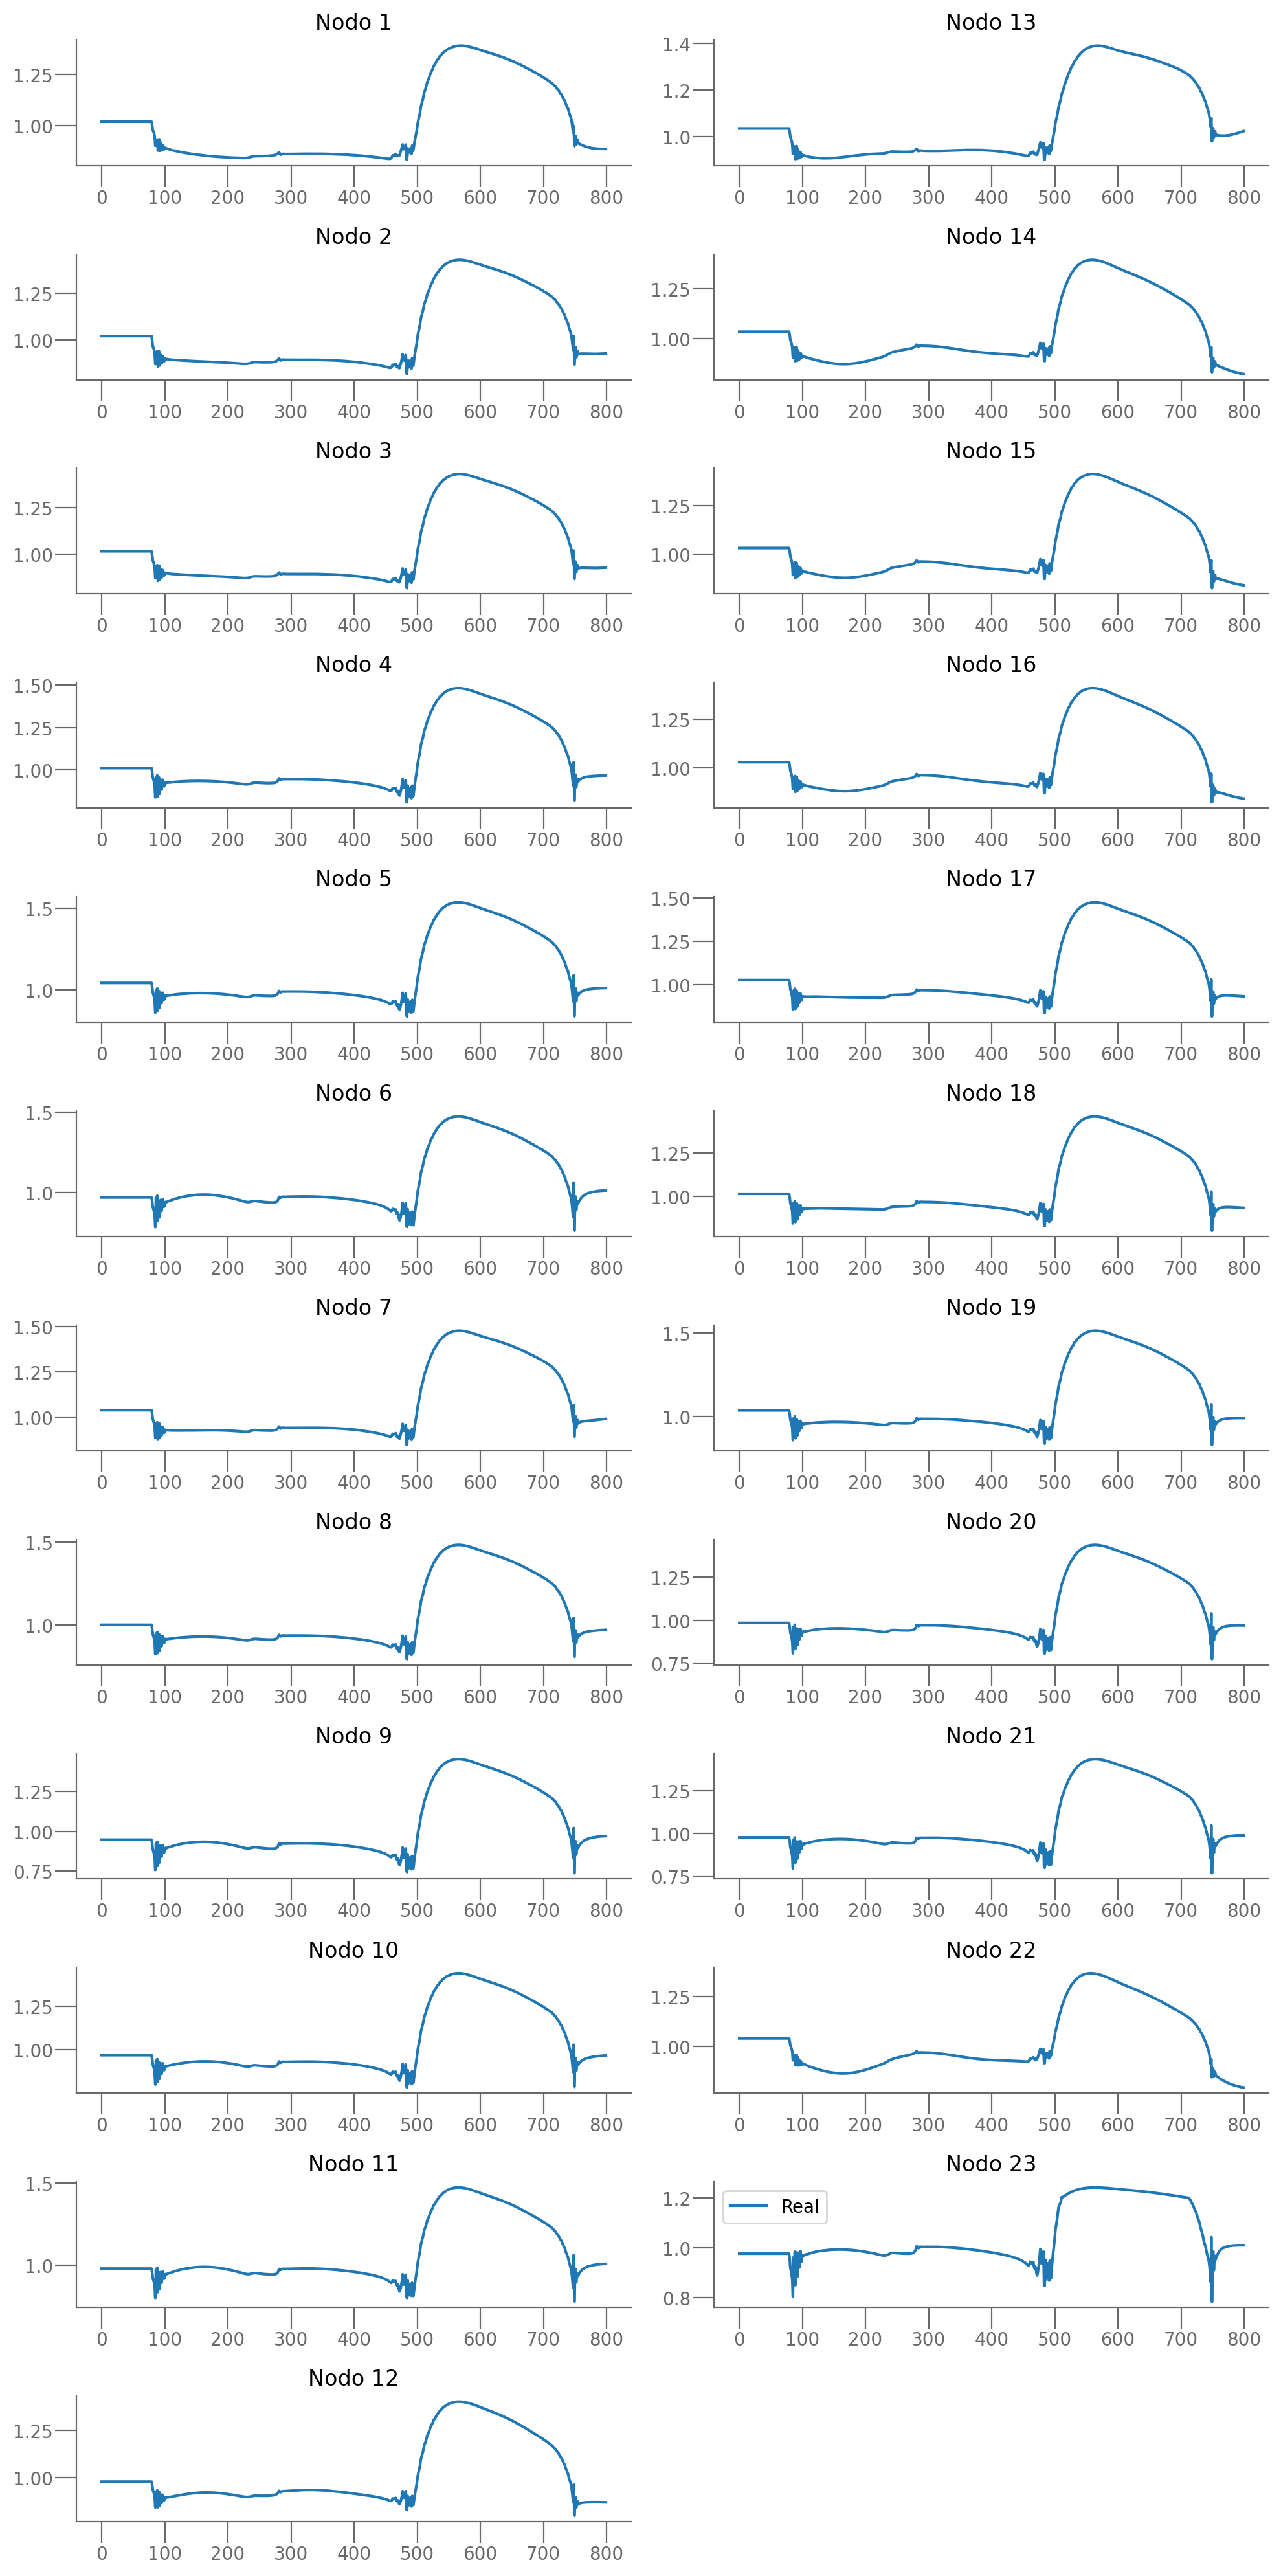

In [50]:
info_nodos = loader.reconstruir_voltages(50)


n_plots = 23
n_cols = 2
n_rows = (n_plots + 1) // 2  # División redondeada hacia arriba

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 20),dpi=200)
# Trazar los gráficos
for i in range(n_plots):
    row = i % n_rows  # Calculamos el índice de la fila
    col = i // n_rows  # Calculamos el índice de la columna
    ax = axs[row, col] if n_plots > 1 else axs
    
    ax = axs[row, col] if n_plots > 1 else axs
    
    sns.lineplot(y=info_nodos[i],x=range(len(info_nodos[i])), ax=ax, label='Real', legend=False)
        
    ax.set_title(f'Nodo {i+1}')
    format_plot(ax)
    # Añadir leyenda solo al último plot
    if i == n_plots - 1:
        ax.legend(loc='upper left')

if n_plots % n_cols != 0:
    fig.delaxes(axs.flatten()[-1])
# Ajustes finales
plt.tight_layout()
plt.show()

In [51]:
n_div = int(len(dataset) // 550)
print(n_div)


2


## Experimentos 

Problema actual: mucho tiempo de entrenamiento - inclusión de batch?


### Red sencilla

In [52]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN
from sklearn.metrics import r2_score



from utils.trainer import TrainerModel
from utils import trainer

In [53]:
dtype = torch.float
device = torch.device("cpu")

In [54]:
n_nodes =dataset.features[0].shape[0]
n_target = dataset.targets[0].shape[1]
n_features = dataset[0].x.shape[1]
embedding_dim =4

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, name):
        self.name  =name
        super(RecurrentGCN, self).__init__()

        self.recurrent = AGCRN(number_of_nodes = n_nodes,
                              in_channels = node_features,
                              out_channels = n_nodes,
                              K = 2,
                              embedding_dimensions = embedding_dim)
        self.linear = torch.nn.Linear(n_nodes,n_target)



    def forward(self, x, e, h):
        h_0 = self.recurrent(x, e, h)
        y = F.relu(h_0)
        y = self.linear(y)
        return y, h_0

In [55]:
model = RecurrentGCN(node_features = n_features, name = "RecurrentGCNInicial")

In [56]:

dataloader_params2 = {
            "batch_size": 20,
            "data_split_ratio": [0.8, 0.1, 0.1],
            "seed": 42
        }
dataloader = trainer.train_test_val_split(dataset, **dataloader_params2)


DataLoader for train set:
Number of batches: 48
DataLoader for val set:
Number of batches: 6
DataLoader for test set:
Number of batches: 6


In [57]:

dataloader_params2 = {
            "batch_size": 40,
            "data_split_ratio": [0.8, 0.1, 0.1],
            "seed": 42
        }
dataloader = trainer.train_test_val_split(dataset, **dataloader_params2)


num_epochs = 5
optimizer = torch.optim.Adam(model.parameters())
model.to(device)

losses = []
e = torch.empty(n_nodes, embedding_dim)
torch.nn.init.xavier_uniform_(e)
i =0
for epoch in range(num_epochs):
    model.train()
    h = None
    for batch in dataloader['train']:
        batch = batch.to(device)

        x = batch.x.view(len(batch), n_nodes, n_features)
        y_hat,h = model(x, e, h)
        loss = F.mse_loss(y_hat.view(-1, n_target), batch.y)
        loss.backward(retain_graph=True)
        losses.append(loss.item())
        optimizer.zero_grad()
        optimizer.step()
        i+=1
        #print("batch: ", i)
    train_loss =torch.FloatTensor(losses).mean().item()
    with torch.no_grad():
        model.eval()
        losses, r2scores = [], []
        for batch in dataloader['val']:
            batch = batch.to(device)
            x = batch.x.view(len(batch), n_nodes, n_features)
            y_hat,h = model(x, e, h)
            loss = F.mse_loss(y_hat.view(-1, n_target), batch.y).item()
            r2scores.append(r2_score(batch.y.cpu(), y_hat.view(-1, n_target).cpu()))
            losses.append(loss)
        eval_loss = torch.tensor(losses).mean().item()
        eval_r2score = np.mean(r2scores)
        
    print(f"Epoch:{epoch}, Training_loss:{train_loss:.4f}, Eval_loss:{eval_loss:.4f}, Eval_r2:{eval_r2score:.4f}, lr:{optimizer.param_groups[0]['lr']}")

DataLoader for train set:
Number of batches: 24
DataLoader for val set:
Number of batches: 3
DataLoader for test set:
Number of batches: 3
Epoch:0, Training_loss:1.0181, Eval_loss:0.9432, Eval_r2:-5.4510, lr:0.001
Epoch:1, Training_loss:1.0096, Eval_loss:0.9434, Eval_r2:-5.4529, lr:0.001
Epoch:2, Training_loss:1.0098, Eval_loss:0.9427, Eval_r2:-5.4478, lr:0.001
Epoch:3, Training_loss:1.0096, Eval_loss:0.9432, Eval_r2:-5.4510, lr:0.001
Epoch:4, Training_loss:1.0097, Eval_loss:0.9425, Eval_r2:-5.4454, lr:0.001


In [78]:
model.eval()
predictions = []
real =[]
losses, r2scores = [], []
for batch in dataloader['test']:
    batch = batch.to(device)
    x = batch.x.view(len(batch), n_nodes, n_features)
    y_hat,h = model(x, e, h)
    loss = F.mse_loss(y_hat.view(-1, n_target), batch.y).item()
    preds = y_hat.view(len(batch), n_nodes, n_target)
    real.append(batch.y.view(len(batch), n_nodes, n_target).cpu())
    predictions.append(preds.cpu().detach().numpy())
    r2scores.append(r2_score(batch.y.detach().cpu(), y_hat.view(-1, n_target).detach().cpu()))
    losses.append(loss)
test_loss = torch.tensor(losses).mean().item()
test_r2score = np.mean(r2scores)

print(f"Test_loss:{test_loss:.4f}, Test_r2:{test_r2score:.4f}")


Test_loss:0.9984, Test_r2:-6.4325


In [77]:
prueba= 
prueba.shape

(23, 200)

In [79]:
def reconstruir_predictions(predictions,real, n_target, situacion, n_div):
    id_situacion = situacion*n_div
    temp = np.array(predictions).reshape(-1, n_nodes, n_target)
    temp2 =np.array(real).reshape(-1, n_nodes, n_target)
    return np.concatenate([np.array(temp[id_situacion+i]) for i in range(n_div)], axis=1), np.concatenate([np.array(temp2[id_situacion+i]) for i in range(n_div)], axis=1)

In [80]:
preds, y_true = reconstruir_predictions(predictions,real, n_target, 0, n_div)

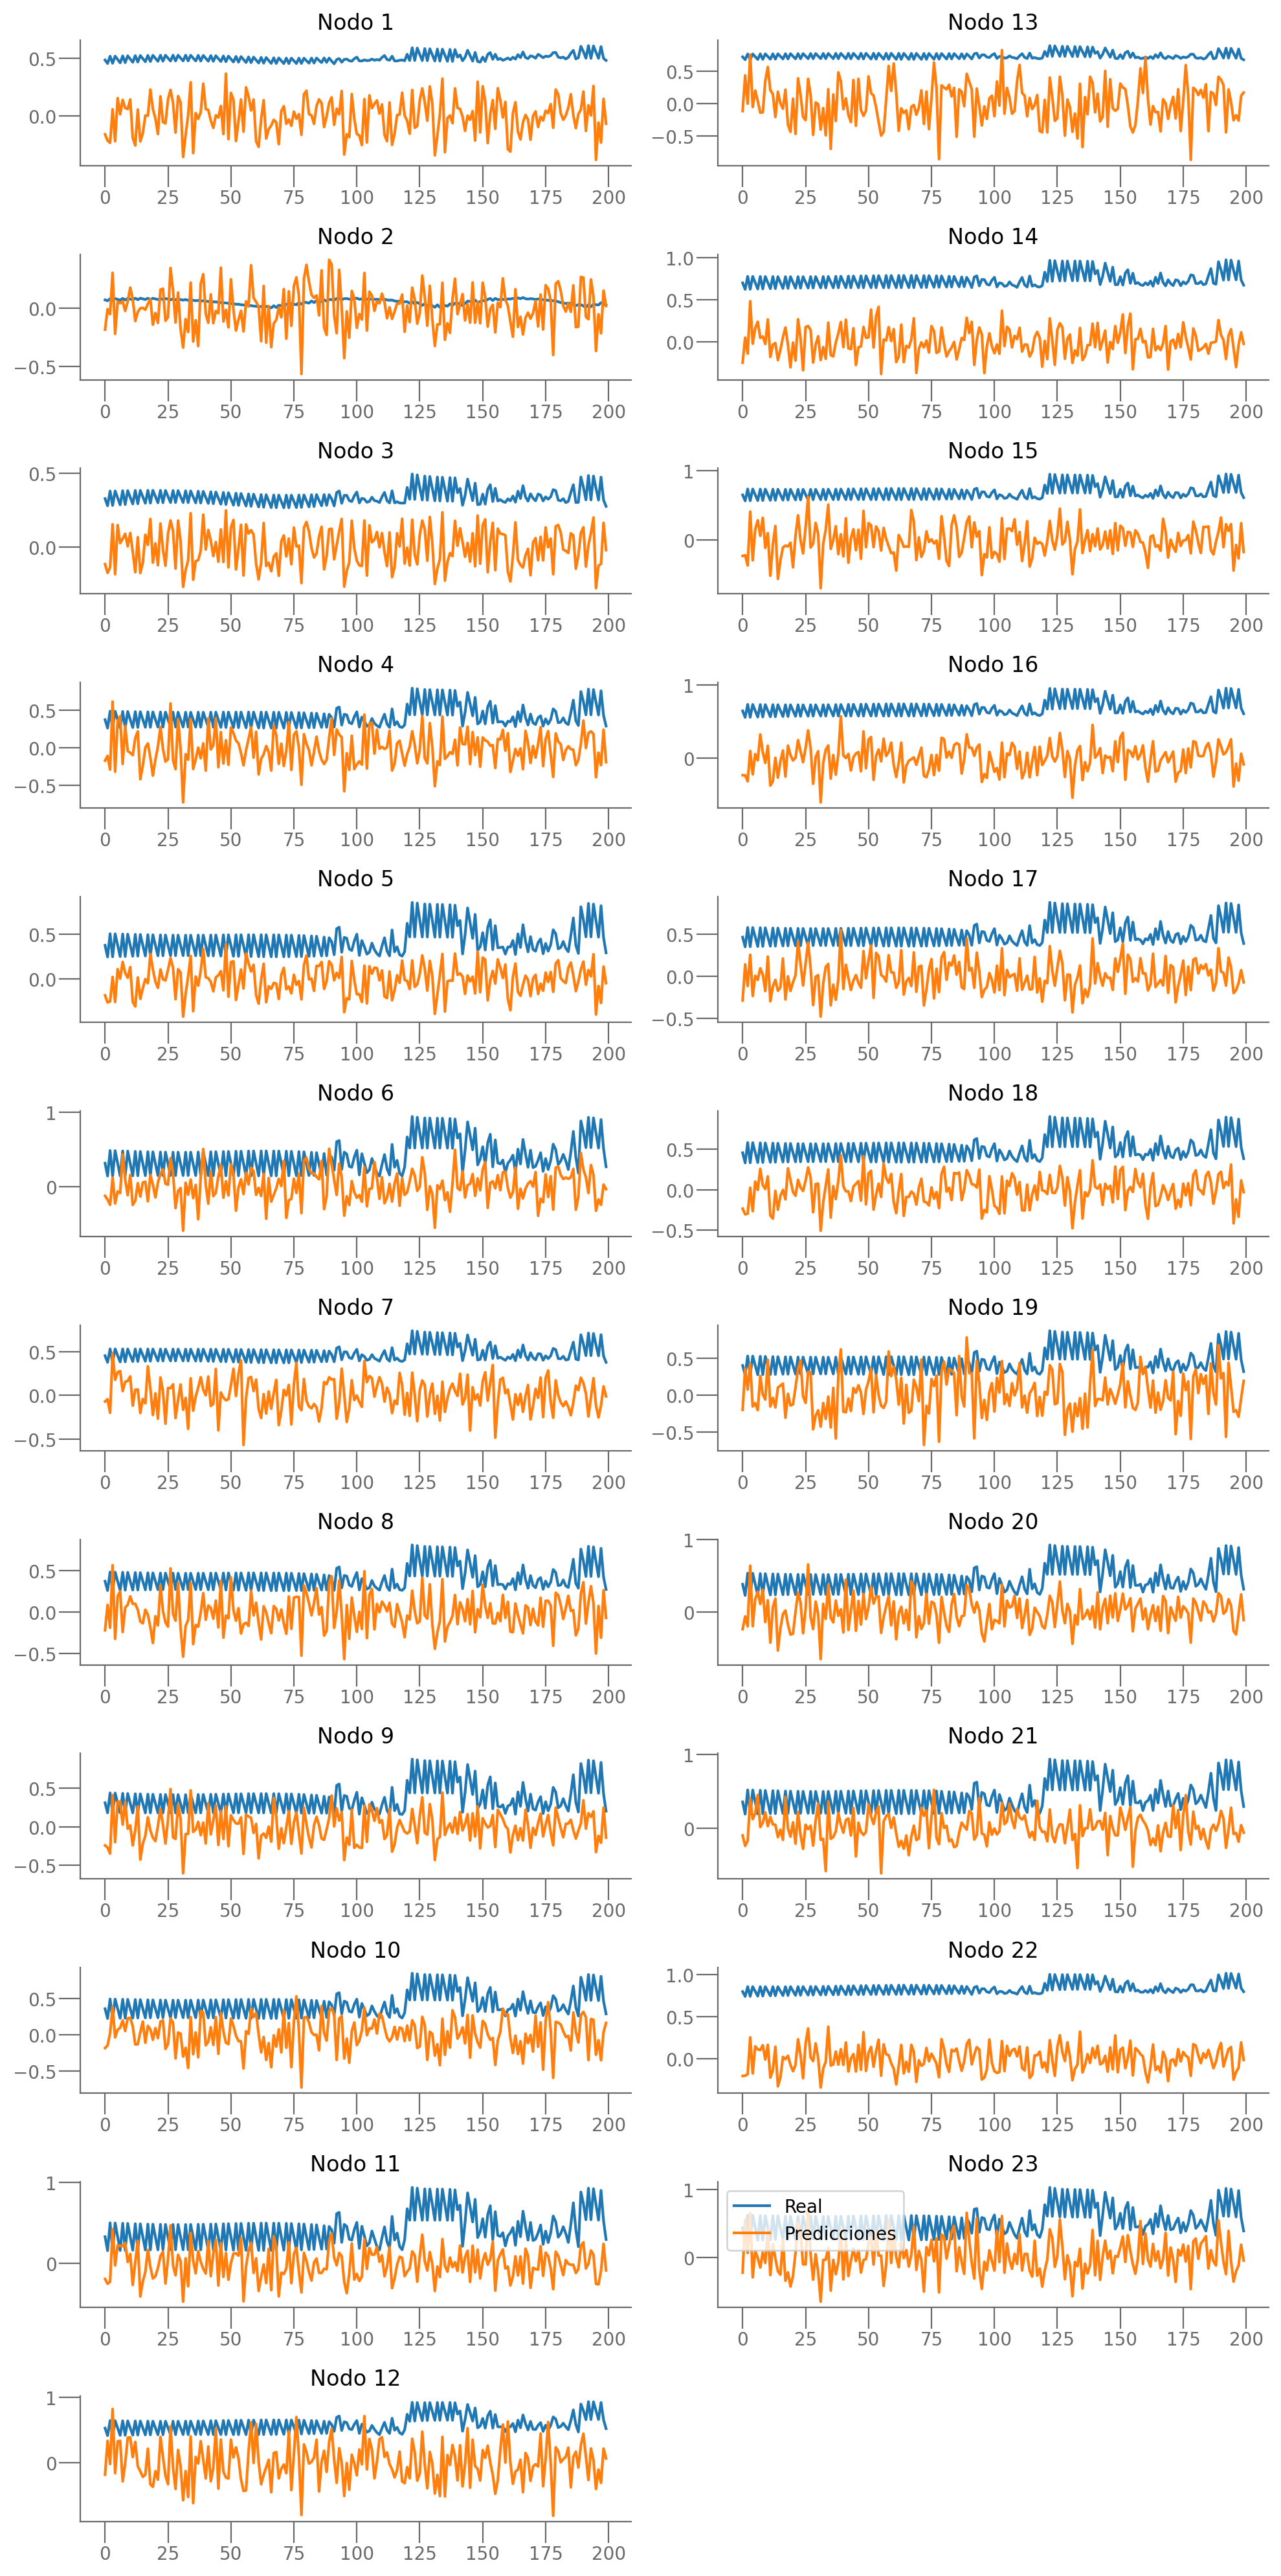

In [84]:
n_situation = 1

n_plots = 23
n_cols = 2
n_rows = (n_plots + 1) // 2  # División redondeada hacia arriba

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 20),dpi=200)
# Trazar los gráficos
for i in range(n_plots):
    row = i % n_rows  # Calculamos el índice de la fila
    col = i // n_rows  # Calculamos el índice de la columna
    ax = axs[row, col] if n_plots > 1 else axs
    
    ax = axs[row, col] if n_plots > 1 else axs
    
    sns.lineplot(y=y_true[i],x=range(n_target*n_div), ax=ax, label='Real', legend=False)
    

    sns.lineplot(y=preds[i],x=range(n_target*n_div),ax=ax, label='Predicciones', legend=False)
    
    ax.set_title(f'Nodo {i+1}')
    format_plot(ax)
    # Añadir leyenda solo al último plot
    if i == n_plots - 1:
        ax.legend(loc='upper left')

if n_plots % n_cols != 0:
    fig.delaxes(axs.flatten()[-1])
# Ajustes finales
plt.tight_layout()
plt.show()

In [27]:


train_params = {
"num_epochs": 5,
"num_early_stop":20
}

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = RecurrentGCN(node_features = n_features, name = "RecurrentGCNInicial")

trainer = TrainerModel(
            model=model,
            dataset=dataset,
            device=device,
            save_dir=os.path.join("./models/", dataset.name),
            dataloader_params=dataloader_params2)




trainer.train(train_params)

DataLoader for train set:
Number of batches: 176
DataLoader for val set:
Number of batches: 23
DataLoader for test set:
Number of batches: 22


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [ ]:

from utils.trainer import TrainerModel
from sklearn.metrics import balanced_accuracy_score, f1_score

In [35]:

model = RecurrentGCN(node_features = n_features)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

e = torch.empty(n_nodes, embedding_dim)

torch.nn.init.xavier_uniform_(e)

tensor([[-0.2497, -0.0414, -0.0629, -0.2463],
        [-0.1819,  0.2027, -0.1274, -0.2180],
        [ 0.3971, -0.4617,  0.0648,  0.3149],
        [-0.1729, -0.2819,  0.1764, -0.4176],
        [-0.3830,  0.2260,  0.0979, -0.2806],
        [ 0.3108, -0.1240, -0.3581, -0.2350],
        [ 0.2648, -0.4062,  0.2846,  0.2135],
        [-0.2635,  0.4128,  0.2368, -0.0828],
        [-0.2650, -0.2636, -0.0254,  0.0988],
        [-0.0123, -0.4485, -0.1291,  0.2317],
        [ 0.2486,  0.0138, -0.0517,  0.0973],
        [-0.2038, -0.0106, -0.0414, -0.1661],
        [-0.2562, -0.2789, -0.3787,  0.1855],
        [ 0.1105, -0.1524, -0.3116,  0.3842],
        [-0.2794, -0.4210, -0.4047,  0.1623],
        [-0.3523, -0.3376,  0.3343,  0.2225],
        [ 0.4685, -0.4326,  0.0081, -0.0721],
        [-0.3664,  0.0676,  0.2443, -0.2844],
        [ 0.2448, -0.2422, -0.0066, -0.2295],
        [-0.0819,  0.0456,  0.3223, -0.4057],
        [ 0.0383, -0.2170, -0.4210,  0.3584],
        [-0.3115, -0.2429,  0.0053

In [36]:
for epoch in tqdm(range(200)):
    cost = 0
    h = None
    for time, snapshot in enumerate(train_dataset):
        x = snapshot.x.view(1, n_nodes, n_features)
        y_hat, h = model(x, e, h)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()


  0%|          | 1/200 [00:13<44:17, 13.35s/it]


KeyboardInterrupt: 

In [ ]:
len(train_dataset.features)

165

In [233]:

predictions = []
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    x = snapshot.x.view(1, n_nodes, n_features)
    y_hat, h = model(x, e, h)
    predictions.append(y_hat.squeeze())
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.0195


In [236]:
def format_plot(ax):
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')

    ax.xaxis.label.set_color('dimgrey')
    ax.tick_params(axis='both', colors='dimgrey', size=12, pad=1)